In [1]:
import json
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Tuple

import pandas as pd
import torch
from PIL import Image
from torch.utils.data import Dataset

In [2]:
data_dir = Path(r"D:\Llava\data")
chat_file = data_dir.joinpath("chat.json")
image_dir = data_dir.joinpath("images")
chat_data = pd.read_json(chat_file)

In [6]:
chat_data.iloc[1]

id                                             GCC_train_002429825
image                                      GCC_train_002429825.jpg
conversations    [{'from': 'human', 'value': '<image>
Write a t...
Name: 1, dtype: object

In [5]:
chat_data.iloc[1].conversations

[{'from': 'human',
  'value': '<image>\nWrite a terse but informative summary of the picture.'},
 {'from': 'gpt',
  'value': '3d vector deluxe alphabet of randomly rotated thin golden symbols .'}]

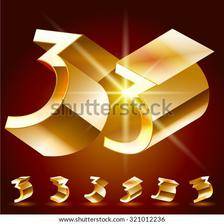

In [8]:
Image.open(image_dir.joinpath(chat_data.iloc[1].image))

In [ ]:
from typing import Dict, List, Tuple

In [3]:
class LlavaDataset(Dataset):
    def __init__(self, dataset_dir: str) -> None:
        super().__init__()

        self.chat_data, self.image_dir = self.build_dataset(dataset_dir)

    def build_dataset(self, data_dir: str) -> Tuple[List[Dict], Path]:
        data_dir = Path(data_dir)
        chat_file = data_dir.joinpath("chat.json")
        image_dir = data_dir.joinpath("images")

        chat_data = pd.read_json(chat_file).to_dict(orient="records")

        return chat_data, image_dir
    
    def __len__(self) -> int:
        return len(self.chat_data)
    
    #__getitem__ 是 Python 中的一个特殊方法,它允许定义对象可以像序列或映射那样被索引或切片。
    # 当你使用 obj[key] 这种语法来访问对象的元素时,Python 实际上会调用对象的 __getitem__ 方法。
    def __getitem__(self, index) -> Tuple[str, str, Path]:
        cur_data = self.chat_data[index]
        conversations = cur_data.get("conversations")

        human_input = conversations[0].get("value")
        chatbot_output = conversations[1].get("value")

        image_path = self.image_dir.joinpath(cur_data.get("image"))
        return human_input, chatbot_output, image_path

In [9]:
test_llavadataset = LlavaDataset(dataset_dir=data_dir)

In [5]:
import torch
from transformers import AutoProcessor, LlavaForConditionalGeneration, LlavaProcessor, GemmaTokenizer, CLIPImageProcessor

class MyLlavaProcessor(LlavaProcessor):
    tokenizer_class = ("LlamaTokenizer", "LlamaTokenizerFast", "GemmaTokenizer")

model_id = r"llava_model\model001"
processor = MyLlavaProcessor(image_processor=CLIPImageProcessor.from_pretrained(model_id), tokenizer=GemmaTokenizer.from_pretrained(model_id))


In [6]:
@dataclass
class QaImageOutput:
    q_input_ids: torch.Tensor
    pixel_values: torch.Tensor
    a_input_ids: torch.Tensor

def build_qaimage(processor:AutoProcessor, q_text:str, a_text:str, image_path: Path) -> None:
    
    raw_image = Image.open(image_path)
    inputs = processor(q_text, raw_image, return_tensors="pt")
    a_input_ids = processor.tokenizer(
        "\n\n"+a_text,
        return_tensors="pt",
        padding="longest",
        truncation=True,
        max_length=1024
    )["input_ids"]
    a_input_ids = a_input_ids[:,1:]
    res = QaImageOutput(
        q_input_ids=inputs.get("input_ids"),
        pixel_values=inputs.get("pixel_values"),
        a_input_ids=a_input_ids,
    )
    return res

In [10]:
c = build_qaimage(processor, *test_llavadataset[1])
c

QaImageOutput(q_input_ids=tensor([[     2,      7,    108,   5559,    476,  12769,    901,  46560,  13367,
            576,    573,   5642, 235265]]), pixel_values=tensor([[[[-0.6974, -0.9018, -1.1061,  ..., -1.0623, -1.0623, -1.0623],
          [-0.6974, -0.9018, -1.1061,  ..., -1.0623, -1.0623, -1.0623],
          [-0.6974, -0.9018, -1.1061,  ..., -1.0623, -1.0623, -1.0623],
          ...,
          [ 1.9303,  1.9303,  1.9303,  ...,  1.9303,  1.9303,  1.9303],
          [ 1.9303,  1.9303,  1.9303,  ...,  1.9303,  1.9303,  1.9303],
          [ 1.9303,  1.9303,  1.9303,  ...,  1.9303,  1.9303,  1.9303]],

         [[-1.2869, -1.4970, -1.7071,  ..., -1.6470, -1.6470, -1.6470],
          [-1.2869, -1.4970, -1.7071,  ..., -1.6470, -1.6470, -1.6470],
          [-1.2869, -1.4970, -1.7071,  ..., -1.6470, -1.6470, -1.6470],
          ...,
          [ 2.0449,  2.0449,  2.0449,  ...,  2.0599,  2.0599,  2.0599],
          [ 2.0449,  2.0449,  2.0449,  ...,  2.0449,  2.0449,  2.0449],
          [ 

In [11]:
class TrainLLavaModelCollator:
    def __init__(self, processor: AutoProcessor, IGNORE_INDEX:int) -> None:
        self.processor = processor
        self.ignore_index = IGNORE_INDEX

    def convert_one_piece(self,
                            q_input_ids: torch.Tensor,
                            a_input_ids: torch.Tensor) -> None:
        input_ids = torch.concat([
            q_input_ids,
            a_input_ids,
            torch.tensor(self.processor.tokenizer.eos_token_id).reshape(1, -1),
        ], axis=1)
        labels = torch.concat([
            torch.full_like(input=q_input_ids, fill_value=self.ignore_index),
            a_input_ids,
            torch.tensor(self.processor.tokenizer.eos_token_id).reshape(1, -1),
        ], axis=1)

        return input_ids, labels
    
    def __call__(self, features:List):

        input_ids_list = []
        labels_list = []
        pixel_values = []
        max_input_len_list = []

        for feature in features:
            qaimage_output = build_qaimage(
                processor=self.processor,
                q_text=feature[0],
                a_text=feature[1],
                image_path=feature[2]
            )
            temp_input_id, temp_labels = self.convert_one_piece(
                q_input_ids=qaimage_output.q_input_ids,
                a_input_ids=qaimage_output.a_input_ids
            )
            max_input_len_list.append(temp_input_id.shape[1])
            input_ids_list.append(temp_input_id)
            labels_list.append(temp_labels)
            pixel_values.append(qaimage_output.pixel_values)
        
        max_input_len = max(max_input_len_list)

        final_input_ids = torch.concat(
            [
                torch.concat(
                    [
                        torch.full(
                            (1, max_input_len - max_input_len_list[index]),
                            self.processor.tokenizer.pad_token_id,
                        ),
                        value,
                    ],
                    axis=1,
                )
                for index, value in enumerate(input_ids_list)
            ]
        )
        final_labels = torch.concat(
            [
                torch.concat(
                    [
                        torch.full(
                            (1, max_input_len - max_input_len_list[index]),
                            self.ignore_index,
                        ),
                        value,
                    ],
                    axis=1,
                )
                for index, value in enumerate(labels_list)
            ]
        )

        final_pixel_values = torch.concat(pixel_values, axis=0)

        attention_mask = torch.ones_like(final_input_ids)
        attention_mask[final_input_ids == self.processor.tokenizer.pad_token_id] = 0

        return {
            "input_ids":final_input_ids,
            "labels":final_labels,
            "pixel_values":final_pixel_values,
            "attention_mask":attention_mask
        }
    
tlmc = TrainLLavaModelCollator(processor, -100)
d = tlmc([test_llavadataset[1],test_llavadataset[2],test_llavadataset[3]])

In [12]:
temp_a, temp_b = tlmc.convert_one_piece(c.q_input_ids, c.a_input_ids)

In [75]:
processor.tokenizer.decode(temp_a[0])

'<bos><image>\nWrite a terse but informative summary of the picture.\n\n3d vector deluxe alphabet of randomly rotated thin golden symbols .<eos>'

In [81]:
d['pixel_values'].shape

torch.Size([3, 3, 336, 336])

In [80]:
processor.tokenizer.decode(d['input_ids'][0])

'<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><bos><image>\nWrite a terse but informative summary of the picture.\n\n3d vector deluxe alphabet of randomly rotated thin golden symbols .<eos>'

In [79]:
d['labels']

tensor([[  -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,    109, 235304, 235258,   4301,
          41707,  40027,    576,  36011,  74571,  11342,  13658,  22013,    954,
              1],
        [  -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,    109,  24827,    574,
           3297,    573,   6915,    724,   9408,  25497,    576,  15586,    954,
              1],
        [  -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,    109,  69645, 154796,    675,
           1700,    611,    476,   5744,   4887,    731,   1700,    576,   9028,
           2970,  21949,  10140,    575,    573,  40325,  68972,   2290, 

In [78]:
d['attention_mask']

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')

In [30]:
c.a_input_ids

[tensor([   109, 235304, 235258,   4301,  41707,  40027,    576,  36011,  74571,
          11342,  13658,  22013,    954])]

In [13]:
import torch
from transformers import AutoProcessor, LlavaForConditionalGeneration, LlavaProcessor, GemmaTokenizer, CLIPImageProcessor

class MyLlavaProcessor(LlavaProcessor):
    tokenizer_class = ("LlamaTokenizer", "LlamaTokenizerFast", "GemmaTokenizer")

model_id = r"llava_model\model001"

model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
).to(0)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [14]:
d.keys()

dict_keys(['input_ids', 'labels', 'pixel_values', 'attention_mask'])

In [15]:
for tk in d.keys():
    d[tk] = d[tk].to(model.device)

model_output = model(**d)

ValueError: The input provided to the model are wrong. The number of image tokens is 3 while the number of image given to the model is 3. This prevents correct indexing and breaks batch generation.